In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
import os

if not os.path.exists('dataset.csv'):
    print("Downloading dataset...")
    !curl -L -o dataset.zip https://www.kaggle.com/api/v1/datasets/download/pedro2025/obd2-panel-opel-2012
    !unzip -o dataset.zip
    print("Unzipped successfully.")
else:
    print("File dataset.csv already exists.")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 18.9M  100 18.9M    0     0  21.1M      0 --:--:-- --:--:-- --:--:-- 45.4M
Archive:  dataset.zip
  inflating: dataset.csv             
Unzipped successfully.


In [4]:
CSV_FILE = 'dataset.csv'
BATCH_SIZE = 1024
MF_COUNT = 3

def load_and_process_data(filepath):
    print(f"Loading: {filepath}...")
    df = pd.read_csv(filepath)

    features = ['RPM', 'THROTTLE_POS']
    target = ['FUEL_USAGE_ML_MIN']

    df = df.dropna(subset=features + target)
    df = df[df['RPM'] > 0]

    return df[features].values, df[target].values

X_raw, y_raw = load_and_process_data(CSV_FILE)

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_x.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw)

# (70% Train, 15% Val, 15% Test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y_scaled, test_size=0.30, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42
)

def create_loader(X, y, shuffle=False):
    tensor_x = torch.tensor(X, dtype=torch.float32)
    tensor_y = torch.tensor(y, dtype=torch.float32)
    dataset = TensorDataset(tensor_x, tensor_y)
    return DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=shuffle)

train_loader = create_loader(X_train, y_train, shuffle=True)
val_loader   = create_loader(X_val, y_val, shuffle=False)
test_loader  = create_loader(X_test, y_test, shuffle=False)

print(f"=== DATA SPLIT ===")
print(f"Training Set:   {len(X_train)} samples")
print(f"Validation Set: {len(X_val)} samples")
print(f"Test Set:       {len(X_test)} samples")

Loading: dataset.csv...
=== DATA SPLIT ===
Training Set:   325158 samples
Validation Set: 69677 samples
Test Set:       69677 samples


In [5]:
class GaussianMF(nn.Module):
    def __init__(self, n_inputs, n_mfs):
        super(GaussianMF, self).__init__()
        self.n_inputs = n_inputs
        self.n_mfs = n_mfs
        self.mu = nn.Parameter(torch.linspace(0, 1, n_mfs).repeat(n_inputs, 1))
        self.sigma = nn.Parameter(torch.ones(n_inputs, n_mfs) * 0.3)

    def forward(self, x):
        x = x.unsqueeze(2)
        exponent = -0.5 * ((x - self.mu) / self.sigma) ** 2
        return torch.exp(exponent)

class ANFIS(nn.Module):
    def __init__(self, n_inputs, n_mfs):
        super(ANFIS, self).__init__()
        self.n_inputs = n_inputs
        self.n_mfs = n_mfs
        self.n_rules = n_mfs ** n_inputs

        self.fuzzify = GaussianMF(n_inputs, n_mfs)

        self.consequent_weights = nn.Parameter(torch.randn(self.n_rules, n_inputs))
        self.consequent_bias = nn.Parameter(torch.randn(self.n_rules))

    def forward(self, x):
        mfs_out = self.fuzzify(x)

        mf_x1 = mfs_out[:, 0, :]
        mf_x2 = mfs_out[:, 1, :]
        w = torch.einsum('bi,bj->bij', mf_x1, mf_x2).reshape(-1, self.n_rules)

        w_sum = torch.sum(w, dim=1, keepdim=True)
        w_norm = w / (w_sum + 1e-8)

        linear_out = torch.matmul(x, self.consequent_weights.t()) + self.consequent_bias
        output = torch.sum(w_norm * linear_out, dim=1, keepdim=True)
        return output

In [6]:
EPOCHS = 100
LEARNING_RATE = 0.01

model = ANFIS(n_inputs=2, n_mfs=MF_COUNT).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_losses = []
val_losses = []

print(f"Starting training on {len(X_train)} samples.")
print(f"Validating every epoch on {len(X_val)} samples.")

for epoch in range(EPOCHS):
    model.train()
    running_train_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * inputs.size(0)

    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item() * inputs.size(0)

    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    epoch_val_loss = running_val_loss / len(val_loader.dataset)

    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)

    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS} | Train MSE: {epoch_train_loss:.5f} | Val MSE: {epoch_val_loss:.5f}")

print("Training finished.")

Starting training on 325158 samples.
Validating every epoch on 69677 samples.
Epoch 5/100 | Train MSE: 0.00013 | Val MSE: 0.00013
Epoch 10/100 | Train MSE: 0.00005 | Val MSE: 0.00006
Epoch 15/100 | Train MSE: 0.00004 | Val MSE: 0.00005
Epoch 20/100 | Train MSE: 0.00003 | Val MSE: 0.00005
Epoch 25/100 | Train MSE: 0.00003 | Val MSE: 0.00005
Epoch 30/100 | Train MSE: 0.00003 | Val MSE: 0.00004
Epoch 35/100 | Train MSE: 0.00003 | Val MSE: 0.00005
Epoch 40/100 | Train MSE: 0.00003 | Val MSE: 0.00004
Epoch 45/100 | Train MSE: 0.00003 | Val MSE: 0.00004
Epoch 50/100 | Train MSE: 0.00003 | Val MSE: 0.00004
Epoch 55/100 | Train MSE: 0.00003 | Val MSE: 0.00004
Epoch 60/100 | Train MSE: 0.00003 | Val MSE: 0.00004
Epoch 65/100 | Train MSE: 0.00003 | Val MSE: 0.00004
Epoch 70/100 | Train MSE: 0.00003 | Val MSE: 0.00004
Epoch 75/100 | Train MSE: 0.00003 | Val MSE: 0.00004
Epoch 80/100 | Train MSE: 0.00003 | Val MSE: 0.00004
Epoch 85/100 | Train MSE: 0.00003 | Val MSE: 0.00004
Epoch 90/100 | Train M

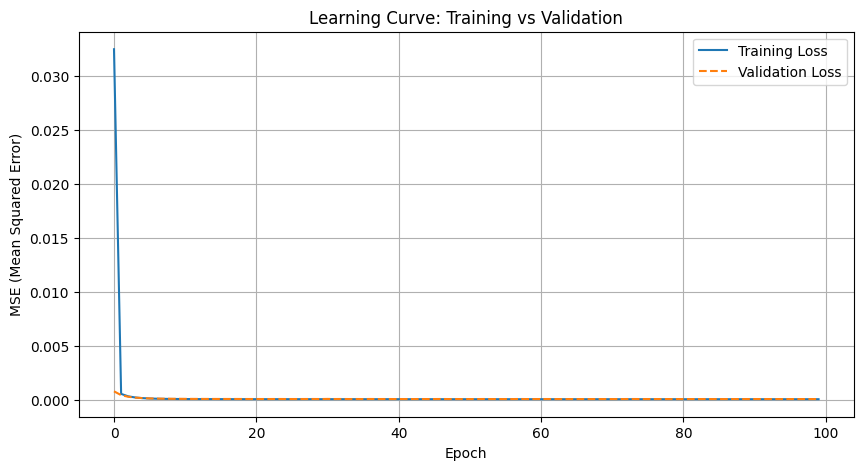

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss', linestyle='--')
plt.title('Learning Curve: Training vs Validation')
plt.xlabel('Epoch')
plt.ylabel('MSE (Mean Squared Error)')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
rpm_real_range = np.linspace(600, 4000, 50)
tps_real_range = np.linspace(10, 70, 50)

rpm_grid, tps_grid = np.meshgrid(rpm_real_range, tps_real_range)

grid_input_real = np.column_stack((rpm_grid.ravel(), tps_grid.ravel()))

grid_input_norm = scaler_x.transform(grid_input_real)
grid_tensor = torch.tensor(grid_input_norm, dtype=torch.float32).to(device)

model.eval()
with torch.no_grad():
    grid_output_norm = model(grid_tensor).cpu().numpy()

fuel_real = scaler_y.inverse_transform(grid_output_norm).reshape(rpm_grid.shape)
fuel_real = np.maximum(0, fuel_real)

fig = go.Figure(data=[go.Surface(
    z=fuel_real,
    x=rpm_grid,
    y=tps_grid,
    colorscale='Jet',
    colorbar_title='Fuel [ml/min]'
)])

fig.update_layout(
    title='Alpha-N Fuel Map',
    scene=dict(
        xaxis_title='RPM',
        yaxis_title='TPS [%]',
        zaxis_title='Fuel Dosage [ml/min]',
        xaxis=dict(range=[600, 4000]),
        yaxis=dict(range=[10, 70]),
        zaxis=dict(range=[0, fuel_real.max()])
    ),
    width=900,
    height=700,
    margin=dict(l=65, r=50, b=65, t=90)
)

fig.show()

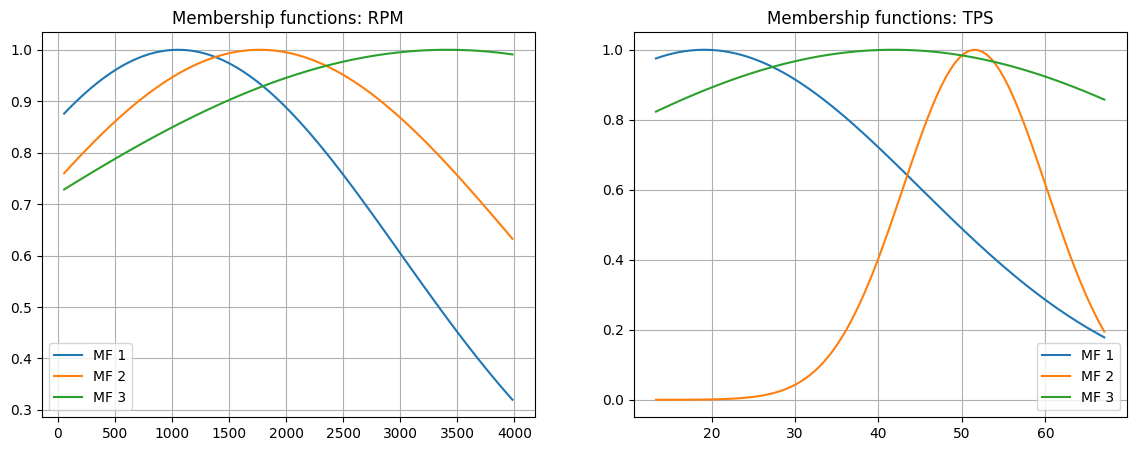

In [15]:
mu = model.fuzzify.mu.detach().cpu().numpy()
sigma = model.fuzzify.sigma.detach().cpu().numpy()
x_axis = np.linspace(0, 1, 100)

plt.figure(figsize=(14, 5))
titles = ['RPM', 'TPS']
for i in range(2):
    plt.subplot(1, 2, i+1)
    for j in range(MF_COUNT):
        y_gauss = np.exp(-0.5 * ((x_axis - mu[i, j]) / sigma[i, j])**2)
        dummy = np.zeros_like(x_axis)
        col = [x_axis, dummy] if i == 0 else [dummy, x_axis]
        x_real = scaler_x.inverse_transform(np.column_stack(col))[:, i]
        plt.plot(x_real, y_gauss, label=f'MF {j+1}')
    plt.title(f'Membership functions: {titles[i]}')
    plt.legend()
    plt.grid()
plt.show()

In [16]:
def evaluate_model(loader, name):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            preds = model(inputs)
            all_preds.append(preds.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    y_pred_scaled = np.vstack(all_preds)
    y_true_scaled = np.vstack(all_targets)

    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_true = scaler_y.inverse_transform(y_true_scaled)

    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    print(f"RMSE for {name} set: {rmse:.2f} ml/min")
    return y_true, y_pred

print("=== FINAL RESULTS ===")
_, _ = evaluate_model(val_loader, "VALIDATION")
y_true_test, y_pred_test = evaluate_model(test_loader, "TEST")

=== FINAL RESULTS ===
RMSE for VALIDATION set: 5.29 ml/min
RMSE for TEST set: 4.30 ml/min


In [17]:
tps_scenarios_pct = [14, 25, 50]
rpm_scenarios_val = [1000, 2500, 3500]

fig = make_subplots(rows=1, cols=2, subplot_titles=("RPM Impact (Constant TPS)", "TPS Impact (Constant RPM)"))

rpm_line = np.linspace(0, 1, 100)
rpm_real_line = scaler_x.inverse_transform(np.column_stack((rpm_line, np.zeros_like(rpm_line))))[:, 0]

for tps_val in tps_scenarios_pct:
    dummy_input = np.array([[0, tps_val]])
    tps_norm = scaler_x.transform(dummy_input)[0, 1]

    inputs = np.column_stack((rpm_line, np.full_like(rpm_line, tps_norm)))
    inputs_tensor = torch.tensor(inputs, dtype=torch.float32).to(device)

    with torch.no_grad():
        preds_scaled = model(inputs_tensor).cpu().numpy()

    preds_real = scaler_y.inverse_transform(preds_scaled).flatten()

    fig.add_trace(
        go.Scatter(x=rpm_real_line, y=preds_real, name=f'TPS = {tps_val}%'),
        row=1, col=1
    )

tps_line = np.linspace(0, 1, 100)
tps_real_line = scaler_x.inverse_transform(np.column_stack((np.zeros_like(tps_line), tps_line)))[:, 1]

for rpm_val in rpm_scenarios_val:
    dummy_input = np.array([[rpm_val, 0]])
    rpm_norm = scaler_x.transform(dummy_input)[0, 0]

    inputs = np.column_stack((np.full_like(tps_line, rpm_norm), tps_line))
    inputs_tensor = torch.tensor(inputs, dtype=torch.float32).to(device)

    with torch.no_grad():
        preds_scaled = model(inputs_tensor).cpu().numpy()

    preds_real = scaler_y.inverse_transform(preds_scaled).flatten()

    fig.add_trace(
        go.Scatter(x=tps_real_line, y=preds_real, name=f'RPM = {rpm_val}'),
        row=1, col=2
    )

fig.update_xaxes(title_text="RPM", row=1, col=1)
fig.update_yaxes(title_text="Fuel Dosage [ml/min]", row=1, col=1)
fig.update_xaxes(title_text="TPS [%]", row=1, col=2)
fig.update_yaxes(title_text="Fuel Dosage [ml/min]", row=1, col=2)
fig.update_layout(title_text="Model Sensitivity Analysis", height=500, width=1000)
fig.show()

In [18]:
SAMPLE_SIZE = 2000
indices = np.random.choice(len(y_test), SAMPLE_SIZE, replace=False)

X_sample = torch.tensor(X_test[indices], dtype=torch.float32).to(device)
y_true_sample_scaled = y_test[indices]

model.eval()
with torch.no_grad():
    y_pred_sample_scaled = model(X_sample).cpu().numpy()

y_true_sample = scaler_y.inverse_transform(y_true_sample_scaled).flatten()
y_pred_sample = scaler_y.inverse_transform(y_pred_sample_scaled).flatten()

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=y_true_sample,
    y=y_pred_sample,
    mode='markers',
    name='Test Samples',
    marker=dict(
        color='royalblue',
        size=5,
        opacity=0.6
    )
))

max_val = max(y_true_sample.max(), y_pred_sample.max())
fig.add_trace(go.Scatter(
    x=[0, max_val],
    y=[0, max_val],
    mode='lines',
    name='Perfect Fit (y=x)',
    line=dict(color='red', dash='dash')
))

fig.update_layout(
    title='Fit Quality: Actual vs Predicted Values',
    xaxis_title='Actual Fuel Dosage [ml/min]',
    yaxis_title='Predicted Fuel Dosage [ml/min]',
    width=800,
    height=800,
    showlegend=True
)

fig.show()

In [19]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

test_loader_full = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                                            torch.tensor(y_test, dtype=torch.float32)),
                              batch_size=4096, shuffle=False)

all_preds = []
all_targets = []
all_inputs = []

model.eval()
with torch.no_grad():
    for inputs, targets in test_loader_full:
        inputs, targets = inputs.to(device), targets.to(device)
        preds = model(inputs)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(targets.cpu().numpy())
        all_inputs.append(inputs.cpu().numpy())

y_pred_test_real = scaler_y.inverse_transform(np.vstack(all_preds)).flatten()
y_true_test_real = scaler_y.inverse_transform(np.vstack(all_targets)).flatten()
X_test_real = scaler_x.inverse_transform(np.vstack(all_inputs))

rpm_test = X_test_real[:, 0]
tps_test = X_test_real[:, 1]

errors = y_pred_test_real - y_true_test_real
abs_errors = np.abs(errors)

SAMPLE_SIZE = 2000
if len(y_pred_test_real) > SAMPLE_SIZE:
    indices = np.random.choice(len(y_pred_test_real), SAMPLE_SIZE, replace=False)
else:
    indices = np.arange(len(y_pred_test_real))

rpm_sample = rpm_test[indices]
tps_sample = tps_test[indices]
true_fuel_sample = y_true_test_real[indices]

rpm_range = np.linspace(600, 4000, 50)
tps_range = np.linspace(10, 70, 50)
rpm_grid, tps_grid = np.meshgrid(rpm_range, tps_range)

grid_input_real = np.column_stack((rpm_grid.ravel(), tps_grid.ravel()))
grid_input_norm = scaler_x.transform(grid_input_real)
with torch.no_grad():
    grid_out = model(torch.tensor(grid_input_norm, dtype=torch.float32).to(device)).cpu().numpy()

fuel_surface = scaler_y.inverse_transform(grid_out).reshape(rpm_grid.shape)
fuel_surface = np.maximum(0, fuel_surface)

fig3d = go.Figure()

fig3d.add_trace(go.Surface(
    z=fuel_surface, x=rpm_grid, y=tps_grid,
    colorscale='Viridis', opacity=0.7, name='ANFIS Model',
    showscale=False
))

fig3d.add_trace(go.Scatter3d(
    x=rpm_sample, y=tps_sample, z=true_fuel_sample,
    mode='markers',
    name='Test Data',
    marker=dict(size=3, color='red', opacity=0.8)
))

fig3d.update_layout(
    title='Final Evaluation: Model Map vs Test Data',
    scene=dict(
        xaxis_title='RPM', yaxis_title='TPS [%]', zaxis_title='Fuel [ml/min]',
        xaxis=dict(range=[600, 4000]), yaxis=dict(range=[10, 70]), zaxis=dict(range=[0, 300])
    ),
    width=900, height=700, margin=dict(l=0, r=0, b=0, t=50)
)
fig3d.show()

fig2 = make_subplots(rows=1, cols=2,
                     subplot_titles=("Error Map (Test)", "Error Histogram (Test)"),
                     horizontal_spacing=0.25)

fig2.add_trace(go.Scatter(
    x=rpm_sample, y=tps_sample,
    mode='markers',
    marker=dict(
        size=5,
        color=abs_errors[indices],
        colorscale='Hot',
        showscale=True,
        colorbar=dict(title="Error [ml]", x=0.42)
    ),
    text=[f"Error: {e:.2f} ml" for e in abs_errors[indices]],
    name='Error'
), row=1, col=1)


fig2.add_trace(go.Histogram(
    x=abs_errors,
    nbinsx=100,
    marker_color='crimson',
    name='Absolute Error'
), row=1, col=2)

fig2.update_xaxes(title_text="RPM", range=[600, 4000], row=1, col=1)
fig2.update_yaxes(title_text="TPS [%]", range=[10, 70], row=1, col=1)
fig2.update_xaxes(title_text="|Prediction - Actual| [ml/min]", row=1, col=2)
fig2.update_yaxes(title_text="Sample Count", row=1, col=2)

fig2.update_layout(title_text="Error Analysis on Test Set", width=1000, height=500)
fig2.show()

mae = np.mean(abs_errors)
rmse = np.sqrt(np.mean(errors**2))
r2 = 1 - (np.sum(errors**2) / np.sum((y_true_test_real - np.mean(y_true_test_real))**2))

print(f"=== FINAL REPORT (TEST SET) ===")
print(f"MAE (Mean Absolute Error):     {mae:.2f} ml/min")
print(f"RMSE (Root Mean Squared Error): {rmse:.2f} ml/min")
print(f"R2 Score (Fit):                 {r2:.4f}")
print(f"Max Error:                      {np.max(abs_errors):.2f} ml/min")

=== FINAL REPORT (TEST SET) ===
MAE (Mean Absolute Error):     2.64 ml/min
RMSE (Root Mean Squared Error): 4.30 ml/min
R2 Score (Fit):                 0.9852
Max Error:                      73.19 ml/min
